# Analyzing artwork
## with Spark + MLlib + Scikit-learn + Seaborn + Lightning

In this tutorial we're going to use a public data set to introduce the distributed analytics library Spark and its machine learning library MLlib, and show how it can be integrated into a Python workflow, including scikit-learn and seaborn and lightning.

The data set is a set of records from the MOMA collection that was just recently open sourced (githhub [repo](https://github.com/MuseumofModernArt/collection)). Each item is a piece of artwork in the collection, with a variety of metadata, such as the Artist, the Department, and the Medium.

The first step in any data analysis workflow is loading the data, so that's where we begin! We're going to load the data with Spark and do some initial processing and analysis, then grab a local sample for visualization.

Load the data from CSV

In [52]:
df = sqlContext.read.format('com.databricks.spark.csv').options(header='true').load('../data/ArtworksScrubbed.csv')

Let's look at the basic layout of the data

In [19]:
df.show(5)

+--------------------+--------------------+---------------+----+--------------------+--------------------+
|             Artists|      Classification|CuratorApproved|Date|          Department|              Medium|
+--------------------+--------------------+---------------+----+--------------------+--------------------+
|         Otto Wagner|A&D Architectural...|              Y|1896|Architecture & De...|Ink and cut-and-p...|
|Christian de Port...|A&D Architectural...|              Y|1987|Architecture & De...|Paint and colored...|
|          Emil Hoppe|A&D Architectural...|              Y|1903|Architecture & De...|Graphite, pen, co...|
|     Bernard Tschumi|A&D Architectural...|              Y|1980|Architecture & De...|Photographic repr...|
|          Emil Hoppe|A&D Architectural...|              Y|1903|Architecture & De...|Graphite, color p...|
+--------------------+--------------------+---------------+----+--------------------+--------------------+



Let's look at the different Departments. We just need to group by the `Department` column, then `count`, then `sort`.

In [4]:
df.groupBy('Department').count().sort('count', ascending=False).show()

+--------------------+-----+
|          Department|count|
+--------------------+-----+
|Prints & Illustra...|57935|
|         Photography|27829|
|Architecture & De...|15745|
|            Drawings|10265|
|Painting & Sculpture| 3716|
|                Film| 2579|
|   Fluxus Collection| 2544|
|Media and Perform...| 2329|
|                null|  374|
|Architecture & De...|   18|
| and pencil on paper|    5|
|              crayon|    1|
| and felt-tip pen...|    1|
| and white tin ca...|    1|
+--------------------+-----+



Those last few look weird. Some of them seem to start with spaces, maybe a glitch in the file. We also want to get rid of any nulls (there are 374). We can get rid of the erroneous rows using a `filter`, and drop the nulls with `dropna`.

In [20]:
filt = df.filter(~(df['Department'].startswith(' '))).dropna()

Now let's recompute our Department counts on the filtered data

In [21]:
cats = filt.groupBy('Department').count().sort('count', ascending=False)
cats.show()

+--------------------+-----+
|          Department|count|
+--------------------+-----+
|Prints & Illustra...|57935|
|         Photography|27829|
|Architecture & De...|15745|
|            Drawings|10265|
|Painting & Sculpture| 3716|
|                Film| 2579|
|   Fluxus Collection| 2544|
|Media and Perform...| 2329|
|Architecture & De...|   18|
+--------------------+-----+



That looks good, let's make a chart! It's easy to convert a `Spark` DataFrame into a `Pandas` DataFrame, which can be better for local analysis and visualization.

In [22]:
local = cats.toPandas()

Setup our plotting using the `seaborn` library

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_context('notebook', font_scale=1.5)

And plot the number of items in each category

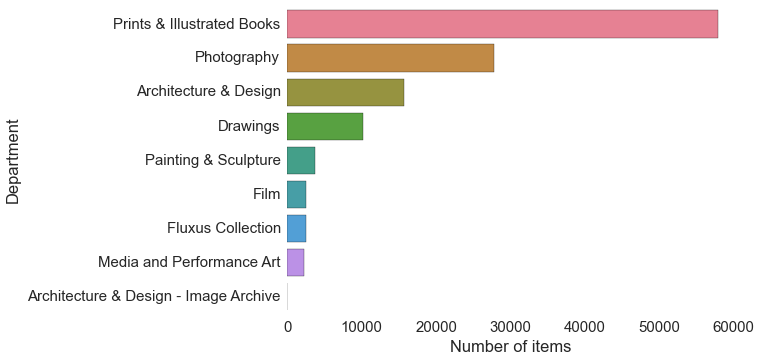

In [154]:
pal = sns.color_palette("husl", 9)
sns.barplot(x='count', y='Department', data=local, palette=pal)
plt.xlabel('Number of items');

In [ ]:
pal = sns.color_palette

In [ ]:
pal = sns.color_palette

We're interested in the relationship between the medium used for the art, and what department it's in. This will be tricky to investigate because the "medium" for each artwork is a collection of words, and they are all different.

In [10]:
filt.select('Medium').show()

+--------------------+
|              Medium|
+--------------------+
|Ink and cut-and-p...|
|Paint and colored...|
|Graphite, pen, co...|
|Photographic repr...|
|Graphite, color p...|
|Gelatin silver ph...|
|Gelatin silver ph...|
|Gelatin silver ph...|
|Gelatin silver ph...|
|Gelatin silver ph...|
|Gelatin silver ph...|
|Gelatin silver ph...|
|Gelatin silver ph...|
|Gelatin silver ph...|
|Gelatin silver ph...|
|Gelatin silver ph...|
|Gelatin silver ph...|
|Gelatin silver ph...|
|Gelatin silver ph...|
|Gelatin silver ph...|
+--------------------+



It'd be nice if we could somehow turn these words into numbers, because that would make it easier to visualize (and to compare across the Departments). A well known algorithm called `word2vec` let's us turn words into numbers (at least, that's more of less the idea, you can read more about it [here]()).

We're going to do this in three steps
- Use Spark's machine learning library to train a `word2vec` model on a corpus of text
- Apply that model to "vectorize" our art words
- Use a local library `scikitlearn` to perform dimensionality reduction and visualize the result

First, load the text data and split it on spaces into words

In [11]:
training = sc.textFile("../data/text8_lines").map(lambda row: row.split(" "))

Import the `word2vec` model from Spark's machine learning library MLlib

In [12]:
from pyspark import SparkContext
from pyspark.mllib.feature import Word2Vec

Train the model (this step might take a minute or so)

In [121]:
word2vec = Word2Vec().setVectorSize(50)
model = word2vec.fit(training)

Let's see if the model did something reasonable by looking for synonyms of the word `red`

In [124]:
model.findSynonyms('green', 5)

[(u'red', 1.4976188604176879),
 (u'yellow', 1.2927484795161142),
 (u'white', 1.287254861497289),
 (u'black', 1.2670357151139555),
 (u'blue', 1.2295567702267318)]

Now let's try to use this to vectorize the medium for each artwork. We're going to collect the words locally, after doing some gnarly unicode to string conversion (this is the stuff no one likes to talk about but is hard to get right!)

In [189]:
samp = filt.sample(False, 0.03, 42)

In [190]:
import unicodedata
mediums = samp.select('Medium').map(lambda item: unicodedata.normalize('NFKD', item.Medium).encode('ascii', 'ignore'))

Collect all the lines

In [191]:
lines = mediums.collect()

Write a function that takes each line and returns the vectorized representation. We have a slight problem in that the medium for each artwork is many words, rather than just one, but one approach is to just take the mean, which is reasonable under the assumption that we are working in a vector space, which is the entire point of `word2vec`!)

In [164]:
import numpy as np

In [165]:
def vectorize(line):
    init = np.zeros(50)
    count = 0
    if line is None:
        return init
    else:
        for word in line.split(' '):
            try:
                vec = model.transform(word).toArray()
                init += vec
                count += 1
            except:
                pass
        if count > 0:
            return init / count
        else:
            return init

Use our function to vectorize each line, and return the result as an array

In [192]:
vectors = np.asarray([vectorize(line) for line in lines])

Let's visualize the result! We have a high-dimensional vector for each piece of artwork, and we want to visualize it in a low dimensional space. A great approach is t-SNE ([link]() to O'Reily tutorial).

In [193]:
from sklearn.manifold import TSNE 

In [194]:
tsne = TSNE(n_components=2)

In [195]:
lowd = tsne.fit_transform(vectors)

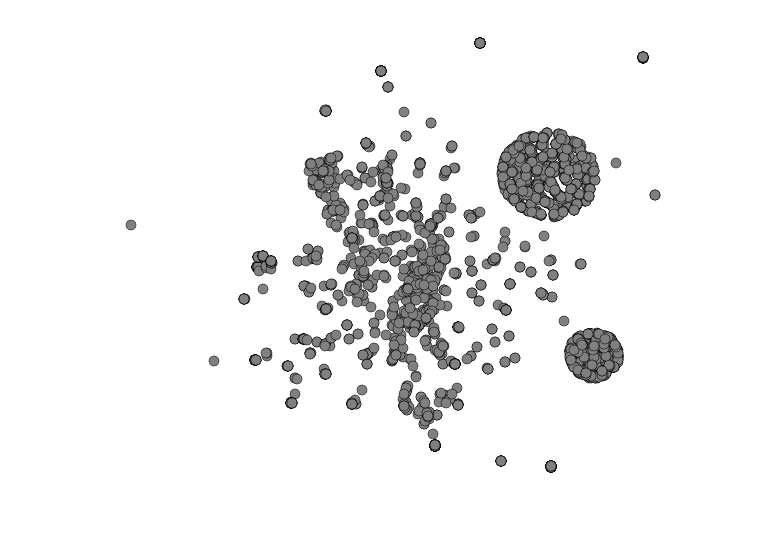

In [213]:
sns.set_context("poster")
plt.scatter(lowd[:,0], lowd[:,1], s=100, c='gray');
plt.axis('off');

Each point here is a piece of artwork, and the distances between them capture similarity in their medium. We would expect there to be some relationship between the medium used and the department the art ends up in. To look for that, we can color the plot by the department.

TODO: replace with interactive version using Lightning

In [214]:
deps = samp.select('Department').map(lambda item: str(item.Department)).collect()

In [215]:
uniq = list(set(deps))
labels = [uniq.index(item) for item in deps]
colors = [pal[l] for l in labels]

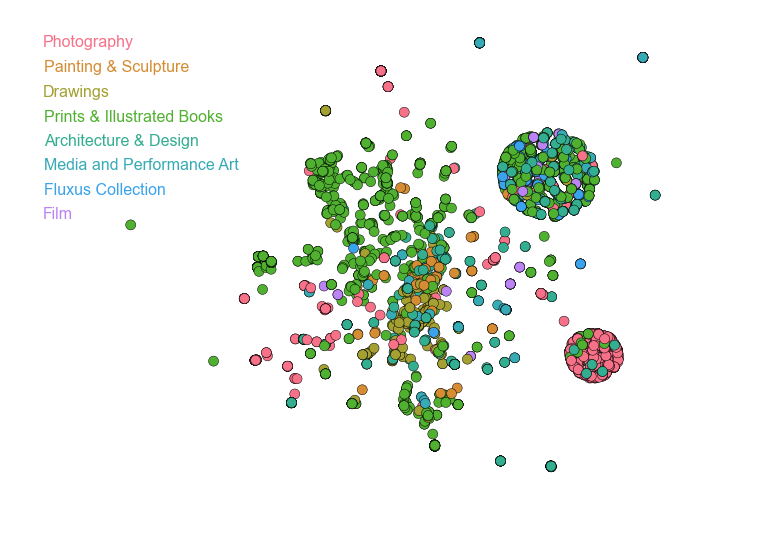

In [247]:
sns.set_context("poster")
plt.scatter(lowd[:,0], lowd[:,1], s=100, c=colors, cmap='hsv')
plt.axis('off')
for i, label in enumerate(uniq):
    plt.text(-25, 13 - i*1.5, label, fontsize=16, fontdict=dict(color=pal[i]))